In [96]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import astra
import pywt

from tqdm import tqdm

%matplotlib inline

# PART A

#### 1. Calculate the Radon transform of an image and test the back-projection method.

##### Load $f_{\text{true}}$

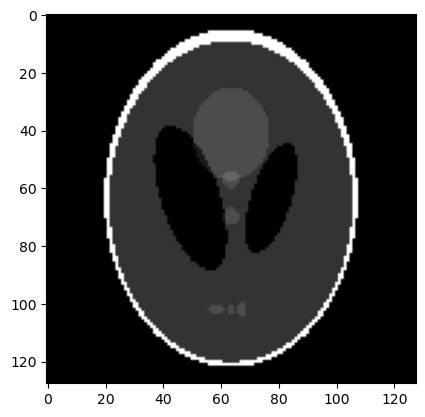

In [167]:
# Load data
SLphantom = np.load('../data/SLphan.npy')

f_true = SLphantom
plt.imshow(f_true, cmap='gray')

##### Generate the Radon transform $g=Rf$

In [98]:
def Randon_Transform(f, det_count=128, angle_count=180, max_angle=np.pi, detector_spacing=1.):
    # Create volume geometries
    v, h = f.shape
    vol_geom = astra.create_vol_geom(v, h)

    # Create projector geometries

    # det_count = int(v / detector_spacing)
    angles = np.linspace(0, max_angle, angle_count, endpoint=False)
    proj_geom = astra.create_proj_geom('parallel', detector_spacing, det_count, angles)

    # Create projector
    projector_id = astra.create_projector('strip', proj_geom, vol_geom)

    # Radon transform (generate sinogram)
    sinogram_id, sinogram = astra.create_sino(f, projector_id)

    return vol_geom, proj_geom, projector_id, sinogram_id, sinogram

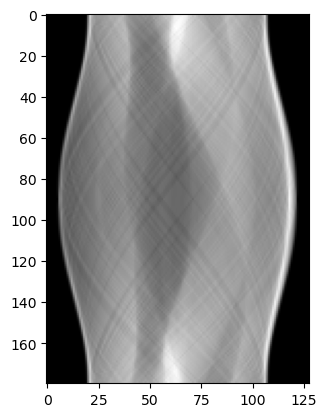

In [99]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true)
plt.imshow(g, cmap='gray')

##### Compute $unfiltered$ back-projection

In [100]:
def Radon_Back_Proj(vol_geom, sinogram_id, projector_id, ptype='BP'):
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction via back-projection
    cfg = astra.astra_dict(ptype)
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['ProjectorId'] = projector_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run back-projection and get the reconstruction
    astra.algorithm.run(alg_id)
    f_rec = astra.data2d.get(rec_id)

    return f_rec

l2 distance:  376814.3861678726


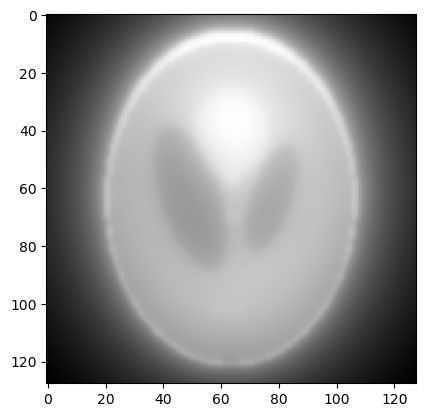

In [101]:
f_rec = Radon_Back_Proj(vol_geom, g_id, proj_id)
print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(f_rec, cmap='gray')

##### Compute $filtered$ back-projection

l2 distance:  7.360654329544242


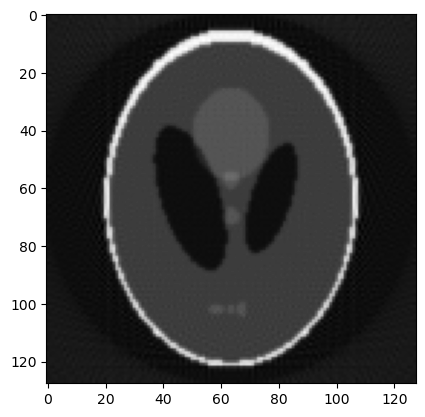

In [102]:
f_filtered_rec = Radon_Back_Proj(vol_geom, g_id, proj_id, ptype='FBP')
print('l2 distance: ', np.linalg.norm(f_filtered_rec - f_true))
plt.imshow(f_filtered_rec, cmap='gray')

##### Add noise to the data $g$

In [103]:
def add_noise_to_sino(proj_geom, sinogram, theta=1.0):
    sinogram_noisy = astra.functions.add_noise_to_sino(sinogram, theta)
    sinogram_noisy_id = astra.data2d.create('-sino', proj_geom, sinogram_noisy)
    return sinogram_noisy_id, sinogram_noisy

In [104]:
# noises = np.linspace(20, 10000, num=100)
noises = np.logspace(1, 2.86, base=25, num=100)
g_l2ds = []
g_vars = []
rec_l2ds = []
vol_geom, proj_geom, proj_id, sinogram_id, sinogram = Randon_Transform(f_true)
n = sinogram.shape[0] * sinogram.shape[1]
for noise in tqdm(noises):
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, sinogram, theta=noise)
    g_l2ds.append(np.linalg.norm(g_noisy - sinogram))
    g_vars.append(np.sqrt(np.sum(np.power(g_noisy - sinogram, 2)) / (n - 1)))
    f_noisy_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, ptype='FBP')
    rec_l2ds.append(np.linalg.norm(f_noisy_rec - f_true))

100%|██████████| 100/100 [00:05<00:00, 16.99it/s]


Text(0, 0.5, '$||f_{rec}-f_{true}||_2$')

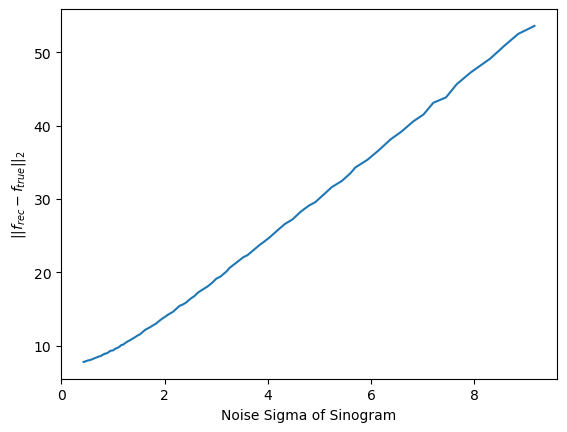

In [105]:
plt.plot(g_vars, rec_l2ds)
plt.xlabel('Noise Sigma of Sinogram')
plt.ylabel('$||f_{rec}-f_{true}||_2$')

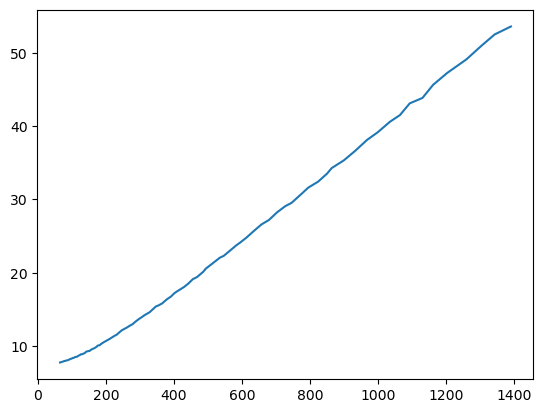

In [106]:
plt.plot(g_l2ds, rec_l2ds)

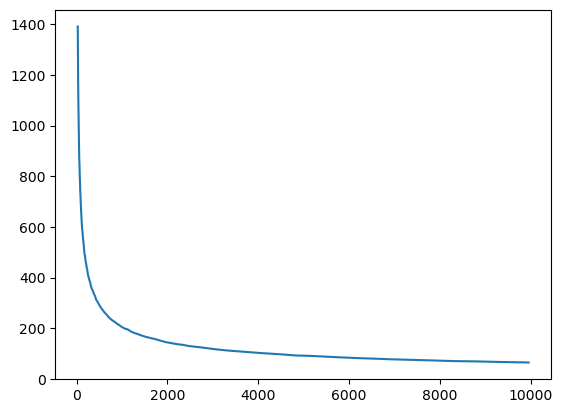

In [107]:
plt.plot(noises, g_l2ds)

#### 2. Calculate an explicit matrix form of the Radon transform and investigate its SVD.

##### Construct explicit matrix of Radon Transform

In [108]:
def construct_Radon_Matrix(h, w, n_angles, max_angle, n_projs):
    
    f = np.zeros((h, w))
    n_pixels = h * w
    R = np.zeros((n_angles * n_projs, n_pixels))
    for i in tqdm(range(n_pixels)):
        r = i // w
        c = i % w
        f[r, c] = 1
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(
            f, det_count=n_projs, angle_count=n_angles, max_angle=max_angle)
        R[:, i] = g.reshape((n_angles * n_projs,))
        f[r, c] = 0
    
    return R

def apply_Radon_Matrix(R, im, n_angles, n_projs):
    h, w = im.shape
    return (R @ im.reshape((h * w))).reshape((n_angles, n_projs))

In [109]:
R = construct_Radon_Matrix(128, 128, 10, np.pi, 128)

100%|██████████| 16384/16384 [00:37<00:00, 433.48it/s]


In [110]:
R45 = construct_Radon_Matrix(128, 128, 10, np.pi / 4, 128)

100%|██████████| 16384/16384 [00:38<00:00, 425.20it/s]


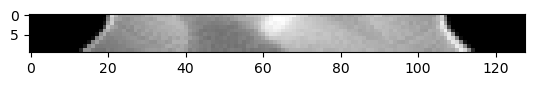

In [120]:
vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(f_true, det_count=128, angle_count=10, max_angle=np.pi/4)
plt.imshow(g, cmap='gray')

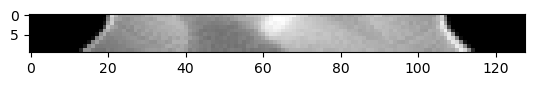

In [112]:
plt.imshow(apply_Radon_Matrix(R45, f_true, 10, 128), cmap='gray')

##### SVD analysis

$\text{i)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:4:179]$

In [113]:
R1 = construct_Radon_Matrix(64, 64, 45, np.pi, 45)

100%|██████████| 4096/4096 [00:09<00:00, 425.89it/s]


In [114]:
U1, s1, Vh1 = scipy.linalg.svd(R1)

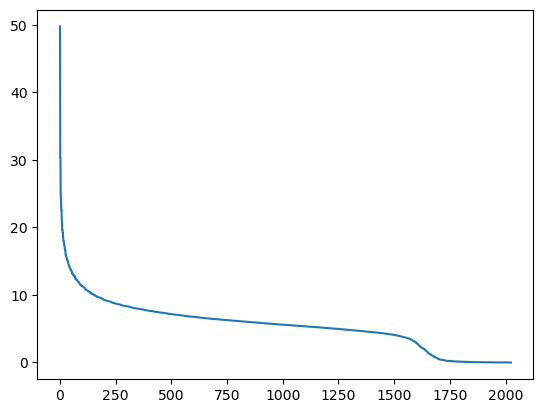

In [115]:
plt.plot(s1)

$\text{ii)}$ $64\times 64$ image, $45$ projection samples, $\text{angles}=[0:1:44]$

In [116]:
R2 = construct_Radon_Matrix(64, 64, 45, np.pi/4, 45)

100%|██████████| 4096/4096 [00:09<00:00, 430.63it/s]


In [117]:
U2, s2, Vh2 = scipy.linalg.svd(R2)

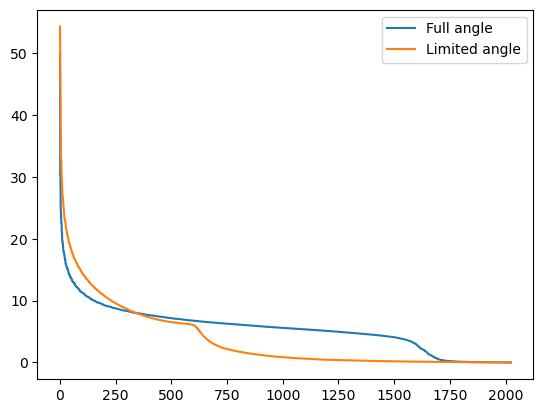

In [118]:
plt.plot(s1, label='Full angle')
plt.plot(s2, label='Limited angle')
plt.legend()

#### 3. Implement a matrix-free regularised least-squares solver for the Radon Transform.

##### Create noisy sinogram 

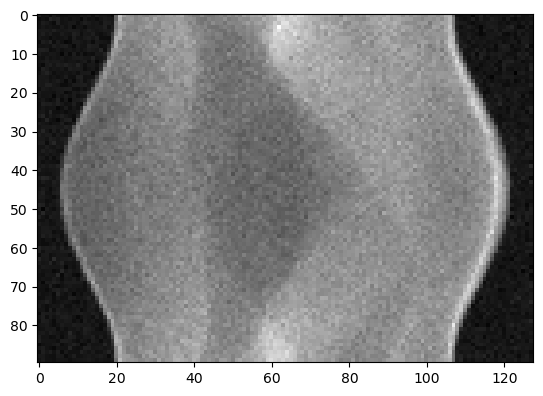

In [173]:
h, w = f_true.shape
n_angles = 90
n_projs = 128
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(g_noisy, cmap='gray')

##### Calculate FBP as baseline

l2 distance:  13.693991553399426
sigma:  1.3469969938718112


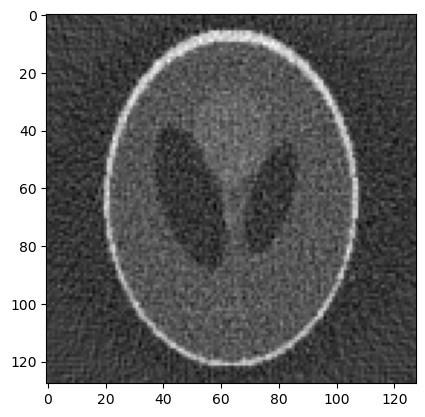

In [174]:
def calculate_noise_sigma(g, g_noisy):
    noise_matrix = g_noisy - g
    n = noise_matrix.shape[0] * noise_matrix.shape[1]
    mu = np.sum(noise_matrix) / n
    sig = np.sqrt(np.sum(np.power(noise_matrix - mu, 2)) / (n - 1))
    return sig

f_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, 'FBP')

sig = calculate_noise_sigma(grt, g_noisy)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
print('sigma: ', sig)
plt.imshow(f_rec, cmap='gray')

##### Construct Matrix free Radon Operator

In [121]:
def construct_Radon_Operator(h, w, n_projs, n_angles, max_angle):

    def forward(v):
        im = v.reshape((h, w))
        vol_geom, proj_geom, proj_id, g_id, g = Randon_Transform(im, n_projs, n_angles, max_angle)
        return g.reshape((n_projs * n_angles,))

    def backward(v):
        g = v.reshape((n_angles, n_projs))
        vol_geom = astra.create_vol_geom(h, w)
        angles = np.linspace(0, max_angle, n_angles, endpoint=False)
        proj_geom = astra.create_proj_geom('parallel', 1., n_projs, angles)
        projector_id = astra.create_projector('strip', proj_geom, vol_geom)
        _, back_projection = astra.create_backprojection(g, projector_id, returnData=True)
        return back_projection.reshape((h * w,))

    return scipy.sparse.linalg.LinearOperator((n_projs * n_angles, h * w), matvec=forward, rmatvec=backward)

def verify_linear_operator(D):
    u = np.random.random((D.shape[1]))
    v = np.random.random((D.shape[0]))
    return np.allclose(np.dot(D @ u, v), np.dot(u, D.T @ v))

def apply_Radon_Back_Projection_Matrix(Rt, g, h, w):
    n_angles, n_projs = g.shape
    return (Rt @ g.reshape((n_angles * n_projs))).reshape((h, w))

In [175]:
R_op = construct_Radon_Operator(h, w, n_projs, n_angles, np.pi)
print(verify_linear_operator(R_op))

True


##### LSQR solver with zero-order Tikhonov regularisation.

In [132]:
def solve_with_zero_TK(alpha, A, g):
    def M_f(v):
        Af = A @ v
        If = np.sqrt(alpha) * v
        z = np.hstack((Af, If))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        Itf = np.sqrt(alpha) * v[h:]
        z = Atf + Itf
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

def dp_alpha_zero_TK(alpha, A, g, sig, h, w, n_angles, n_projs):
    gh, gw = g.shape
    x_lsqr = solve_with_zero_TK(alpha, A, g.reshape((gh * gw)))
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(R_op, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return np.abs(dp_alpha)

def zero_TK_Radon_solver(f_true, A, g, sig, h, w, n_angles, n_projs):
    
    sol = scipy.optimize.minimize_scalar(dp_alpha_zero_TK, bounds=(1e-6, 1e3), 
                                        args=(A, g, sig, h, w, n_angles, n_projs),
                                        method='bounded')
    print(sol)
    alpha = sol.x.item()
    gh, gw = g.shape
    x_lsqr = solve_with_zero_TK(alpha, A, g.reshape((gh * gw)))
    f_rec_lsqr = x_lsqr[0].reshape((128, 128))
    l2 = np.linalg.norm(f_rec_lsqr - f_true)
    print('l2 distance: ', l2)
    # plt.imshow(f_rec_lsqr, cmap='gray')

    return f_rec_lsqr, l2, alpha

     fun: 8.223211378499684e-08
 message: 'Solution found.'
    nfev: 29
     nit: 29
  status: 0
 success: True
       x: 99.55681260630362
l2 distance:  11.996735328621044


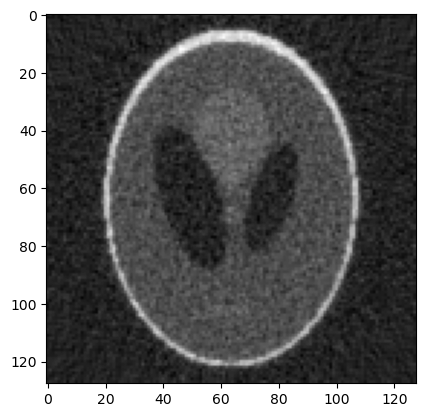

In [134]:
f_rec_0tk, l2_0tk, alpha_0tk = zero_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_0tk, cmap='gray')

##### LSQR solver with first-order Tikhonov regularisation.

In [162]:
def construct_delta_xy(h, w):
    d = scipy.sparse.diags([1, -1], [0, 1], shape=(w, w))
    ri = np.eye(h)
    gx = scipy.sparse.kron(ri, d)
    gy = scipy.sparse.kron(d, ri)
    return gx, gy
def apply_gradient_to_image(g, im):
    h, w = im.shape
    imv = im.reshape((h * w,))
    gim = g @ imv
    return gim.reshape((h, w))

In [163]:
def solve_with_first_TK(alpha, A, g, h, w):
    gx, gy = construct_delta_xy(h, w)
    def M_f(v):
        Af = A @ v
        gfx = np.sqrt(alpha) * gx @ v
        gfy = np.sqrt(alpha) * gy @ v
        z = np.hstack((Af, gfx, gfy))
        return z
    def MT_b(v):
        h, w = A.shape
        Atf = A.T @ v[:h]
        gfxt = np.sqrt(alpha) * gx.T @ v[h:h+w]
        gfyt = np.sqrt(alpha) * gy.T @ v[h+w:h+w+w]
        z = Atf + gfxt + gfyt
        return z
    h, w = A.shape
    M = scipy.sparse.linalg.LinearOperator((h + w + w, w), matvec=M_f, rmatvec=MT_b)
    b = np.hstack((g, np.zeros(w), np.zeros(w)))
    x_lsqr = scipy.sparse.linalg.lsqr(M, b)
    return x_lsqr

def dp_alpha_first_TK(alpha, A, g, sig, h, w, n_angles, n_projs):
    gh, gw = g.shape
    x_lsqr = solve_with_first_TK(alpha.item(), A, g.reshape((gh * gw)), h, w)
    f_rec_lsqr = x_lsqr[0].reshape((h, w))
    Af = apply_Radon_Matrix(A, f_rec_lsqr, n_angles, n_projs)
    r_alpha_norm = np.linalg.norm(Af - g)
    dp_alpha = r_alpha_norm * r_alpha_norm / (gh * gw) - sig * sig
    return np.abs(dp_alpha)

def first_TK_Radon_solver(f_true, A, g, sig, h, w, n_angles, n_projs):
    sol = scipy.optimize.minimize_scalar(dp_alpha_first_TK, bounds=(1e-6, 1e3), 
                                     args=(A, g, sig, h, w, n_angles, n_projs),
                                     method='bounded')
    print(sol)
    alpha = sol.x.item()
    gh, gw = g.shape
    x_lsqr = solve_with_first_TK(alpha, A, g.reshape((gh * gw)), h, w)
    f_rec_lsqr = x_lsqr[0].reshape((128, 128))
    l2 = np.linalg.norm(f_rec_lsqr - f_true)
    print('l2 distance: ', l2)

    return f_rec_lsqr, l2, alpha

     fun: 8.223211378499684e-08
 message: 'Solution found.'
    nfev: 33
     nit: 33
  status: 0
 success: True
       x: 94.84531578483703
l2 distance:  11.845132837760834


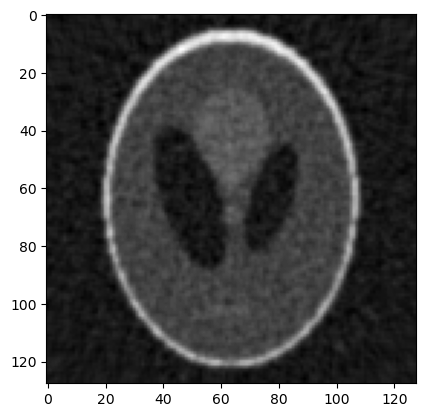

In [140]:
f_rec_1tk, l2_1tk, alpha_1tk = first_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_1tk, cmap='gray')

##### Baseline: Full range but small number of angles

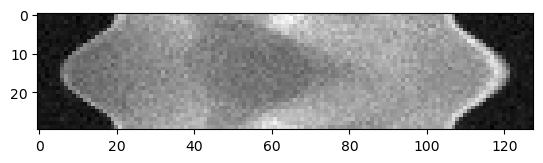

In [141]:
h, w = f_true.shape
n_angles = 30
n_projs = 128
max_angle = np.pi
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(g_noisy, cmap='gray')

l2 distance:  13.693991553399426
sigma:  1.3469969938718112


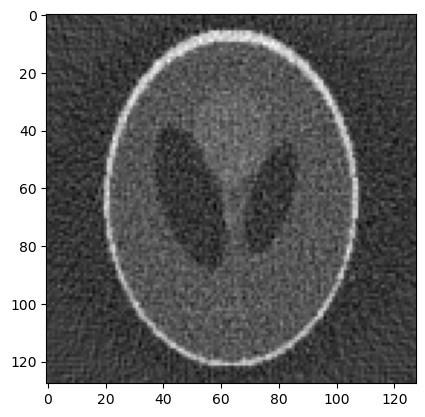

In [176]:
f_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, 'FBP')

sig = calculate_noise_sigma(grt, g_noisy)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
print('sigma: ', sig)
plt.imshow(f_rec, cmap='gray')

In [150]:
R_op = construct_Radon_Operator(h, w, n_projs, n_angles, max_angle)

+ LSQR solver with zero-order Tikhonov regularisation

     fun: 1.4176351759154215e-07
 message: 'Solution found.'
    nfev: 28
     nit: 28
  status: 0
 success: True
       x: 54.225536708602824
l2 distance:  14.974118744010017


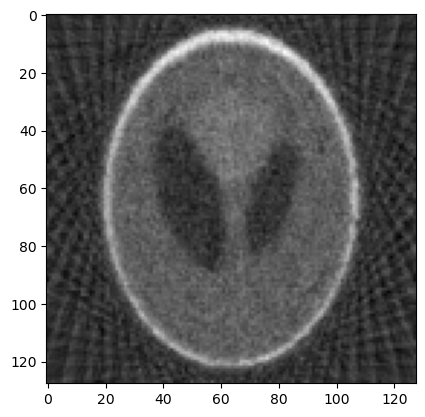

In [145]:
f_rec_0tk, l2_0tk, alpha_0tk = zero_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_0tk, cmap='gray')

+ LSQR solver with fisrt-order Tikhonov regularisation

     fun: 4.940193598645948e-07
 message: 'Solution found.'
    nfev: 32
     nit: 32
  status: 0
 success: True
       x: 83.11122102874937
l2 distance:  14.589068749015205


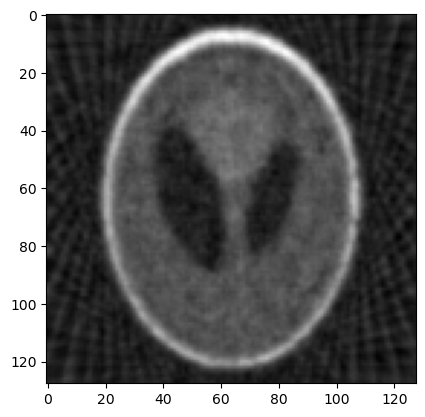

In [146]:
f_rec_1tk, l2_1tk, alpha_1tk = first_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_1tk, cmap='gray')

##### Baseline: limited angles

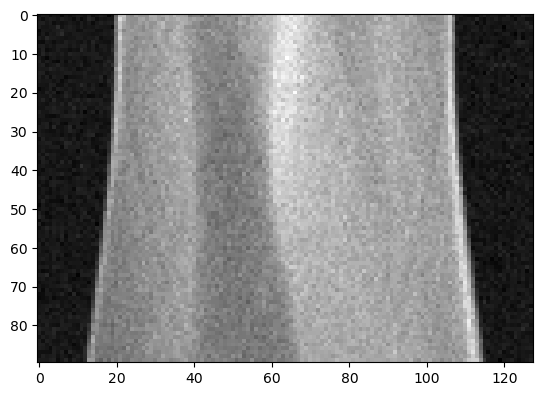

In [178]:
h, w = f_true.shape
n_angles = 90
n_projs = 128
max_angle = np.pi / 4
vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)
g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=1000)
plt.imshow(g_noisy, cmap='gray')

l2 distance:  41.591622019359136
sigma:  1.3481003631014534


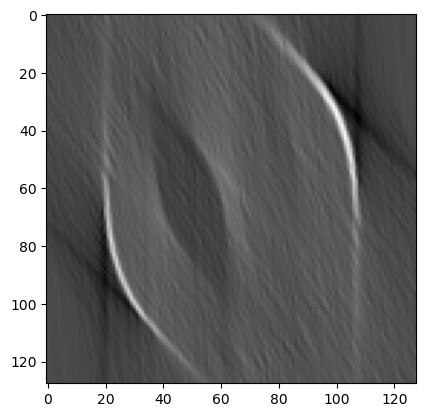

In [179]:
f_rec = Radon_Back_Proj(vol_geom, g_nosiy_id, proj_id, 'FBP')

sig = calculate_noise_sigma(grt, g_noisy)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
print('sigma: ', sig)
plt.imshow(f_rec, cmap='gray')

In [149]:
R_op = construct_Radon_Operator(h, w, n_projs, n_angles, max_angle)

+ LSQR solver with zero-order Tikhonov regularisation

     fun: 1.7220614267898782e-08
 message: 'Solution found.'
    nfev: 26
     nit: 26
  status: 0
 success: True
       x: 137.4306843148046
l2 distance:  21.1256704321421


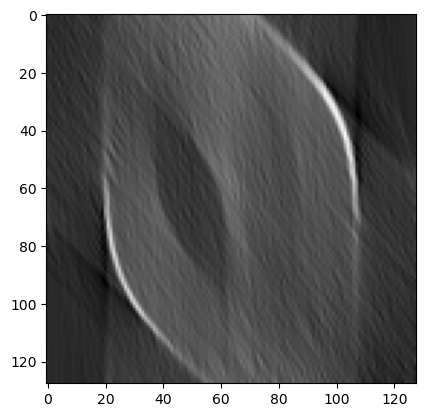

In [151]:
f_rec_0tk, l2_0tk, alpha_0tk = zero_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_0tk, cmap='gray')

+ LSQR solver with fisrt-order Tikhonov regularisation

     fun: 1.7220614267898782e-08
 message: 'Solution found.'
    nfev: 27
     nit: 27
  status: 0
 success: True
       x: 106.9564110495982
l2 distance:  20.29395286662386


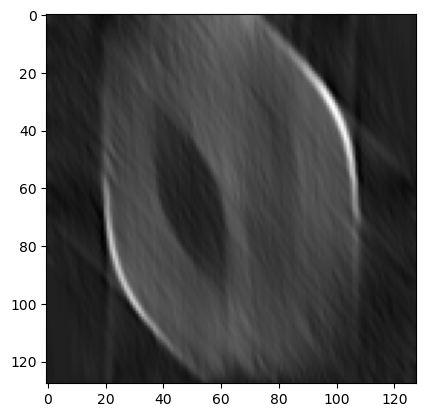

In [152]:
f_rec_1tk, l2_1tk, alpha_1tk = first_TK_Radon_solver(f_true, R_op, g_noisy, sig, h, w, n_angles, n_projs)
plt.imshow(f_rec_1tk, cmap='gray')

#### 4. Write a Haar wavelet denoiser

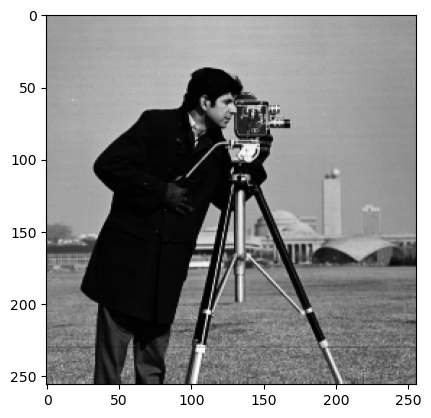

In [180]:
cam_true = plt.imread('../data/Cameraman256.png')
plt.imshow(cam_true, cmap='gray')

In [191]:
def wavelet_decompose(data, wavelet_type, level):
    coeffs = pywt.wavedec2(data, wavelet_type, level=level)
    return coeffs

def wavelet_reconstruct(data, wavelet_type):
    f_rec = pywt.waverec2(data, wavelet_type)
    return f_rec

def extract_coeffs(coeffs):
    level = len(coeffs) - 1
    all_coeffs = []
    for i in range(1, level + 1):
        for c in coeffs[i]:
            all_coeffs.extend(c.flatten().tolist())
    all_coeffs = np.array(all_coeffs)
    non0_coeffs = all_coeffs[np.where(all_coeffs!=0)]
    abs_coeffs = np.abs(non0_coeffs)
    return non0_coeffs[np.argsort(abs_coeffs)]

def determine_abs_threshold(x, coeffs):
    non0_coeffs = extract_coeffs(coeffs)
    cn = non0_coeffs.shape[0]
    return np.abs(non0_coeffs[int(cn * x)])

def threshold_coeffs(coeffs, threshold, level, threshold_fucntion=None):
    new_coeffs = ()
    for c in coeffs[level]:
        if threshold_fucntion:
            new_coeffs += (threshold_fucntion(c, threshold),)
        else:
            new_coeffs += (pywt.threshold(c, threshold, mode='garrote', substitute=0),)
    coeffs[level] = new_coeffs

def threshold_specific_levels(coeffs, threshold, levels, threshold_fucntion=None):
    for level in levels:
        threshold_coeffs(coeffs, threshold, level, threshold_fucntion)

def visualize_haar_coeffs(coeffs):
    A = coeffs[0]
    for coeff in coeffs[1:]:
        A = np.vstack((np.hstack((A, coeff[0])), np.hstack((coeff[1], coeff[2]))))
    plt.imshow(A, cmap='gray')
    return A

def wavelet_denoise(f_noisy, wavelet_type, level, threshold_coeff, threshold_levels):

    coeffs = wavelet_decompose(f_noisy, wavelet_type, level=level)
    threshold = determine_abs_threshold(threshold_coeff, coeffs)
    threshold_specific_levels(coeffs, threshold, threshold_levels)
    f_rec = wavelet_reconstruct(coeffs, wavelet_type)
    
    return f_rec

##### Haar wavelet transform

array([[ 2.4647059e+00,  2.4764705e+00,  2.4725490e+00, ...,
        -3.9215744e-03, -9.8039471e-03, -7.8431275e-03],
       [ 2.4500000e+00,  2.4509802e+00,  2.4499998e+00, ...,
        -3.9215744e-03, -9.8039471e-03, -7.8431275e-03],
       [ 2.4362745e+00,  2.4676471e+00,  2.4892154e+00, ...,
         9.8039052e-03,  2.9411756e-02, -1.9607977e-03],
       ...,
       [-4.9019605e-02,  9.6078366e-02, -6.8627477e-02, ...,
        -8.4313713e-02, -3.5294097e-02, -6.8627454e-02],
       [-1.5686303e-02,  6.0784340e-02, -2.2156861e-01, ...,
         4.3137278e-02, -8.6274512e-02, -3.7254926e-02],
       [-1.5686303e-02, -1.2549013e-01, -2.2745100e-01, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

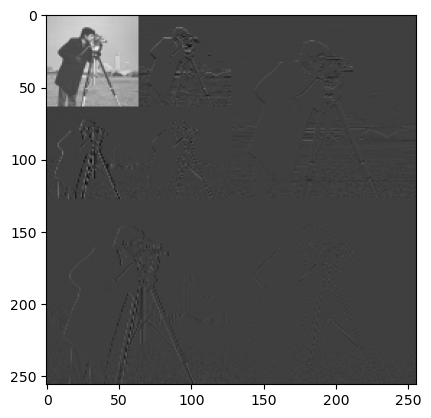

In [198]:
wavelet_type = 'haar'
level = 2
coeffs = wavelet_decompose(cam_true, wavelet_type, level=level)
visualize_haar_coeffs(coeffs)

##### Haar wavelet reconstruction

l2 distance:  2.1841588e-05


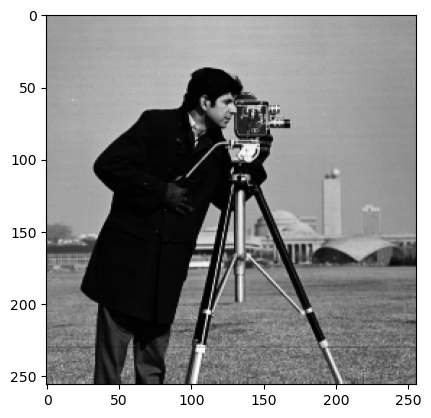

In [200]:
wavelet_type = 'haar'
level = 2
coeffs = wavelet_decompose(cam_true, wavelet_type, level=level)
w_rec = wavelet_reconstruct(coeffs, wavelet_type)
print('l2 distance: ', np.linalg.norm(w_rec - cam_true))
plt.imshow(w_rec, cmap='gray')

##### Haar Denoiser

0.1426087117419033


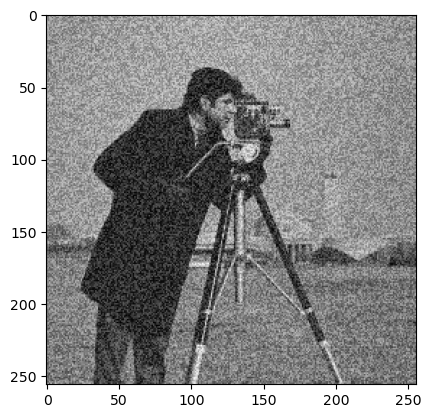

In [201]:
noiselevel = 0.5
immax = np.max(cam_true)
cam_noisy = cam_true + noiselevel * immax * np.random.random(cam_true.shape)

sig = calculate_noise_sigma(cam_true, cam_noisy)
print(sig)

plt.imshow(cam_noisy, cmap='gray')

array([[ 2.80818878e+01,  2.91356135e+01,  3.03865288e+01, ...,
        -5.47454452e-02, -4.57789582e-02,  1.05955071e-01],
       [ 2.86241270e+01,  2.99620405e+01,  3.05781870e+01, ...,
        -1.89610906e-02, -4.98720585e-02,  2.92645277e-01],
       [ 2.88199633e+01,  2.44110606e+01,  1.12518049e+01, ...,
         2.24335988e-01,  1.88804293e-01,  8.17521723e-02],
       ...,
       [ 1.82694500e-01,  2.34489004e-01,  9.61657802e-02, ...,
        -2.10055102e-02,  4.11611403e-02, -1.78282961e-01],
       [ 4.42174132e-02,  1.97297934e-01, -1.81737438e-01, ...,
         1.96327085e-01, -2.88155858e-01,  3.24925628e-02],
       [-1.68641853e-01, -2.10976878e-01,  4.62140774e-02, ...,
         1.36012348e-01,  3.72473895e-02,  6.98443774e-02]])

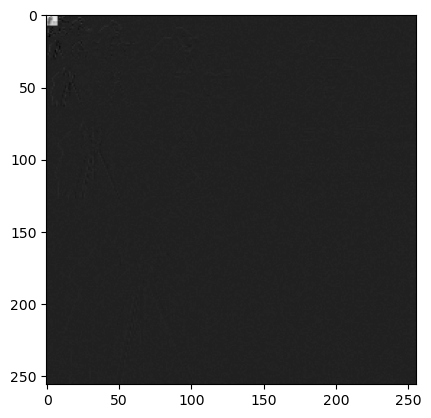

In [204]:
wavelet_type = 'haar'
level = 5
coeffs = wavelet_decompose(cam_noisy, wavelet_type, level=level)
visualize_haar_coeffs(coeffs)

l2 distance:  65.85632968382689


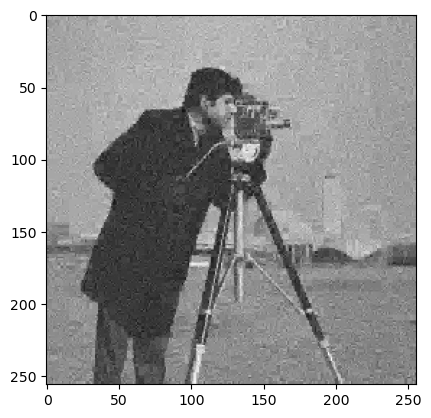

In [187]:
wavelet_type = 'haar'
level = 5
threshold_coeff = 0.8
threshold_levels = range(1, level + 1)

w_rec = wavelet_denoise(cam_noisy, wavelet_type, level, threshold_coeff, threshold_levels)

print('l2 distance: ', np.linalg.norm(w_rec - cam_true))
plt.imshow(w_rec, cmap='gray')

l2 distance:  73.05018996739875


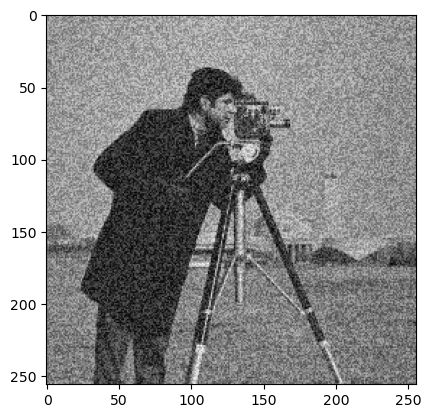

In [202]:
wavelet_type = 'haar'
level = 5
threshold_coeff = 0.8
threshold_levels = range(1, 2)

w_rec = wavelet_denoise(cam_noisy, wavelet_type, level, threshold_coeff, threshold_levels)

print('l2 distance: ', np.linalg.norm(w_rec - cam_true))
plt.imshow(w_rec, cmap='gray')

l2 distance:  71.87944965102338


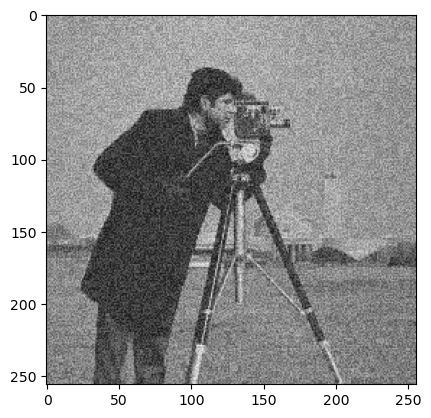

In [203]:
wavelet_type = 'haar'
level = 5
threshold_coeff = 0.8
threshold_levels = [2, 4]

w_rec = wavelet_denoise(cam_noisy, wavelet_type, level, threshold_coeff, threshold_levels)

print('l2 distance: ', np.linalg.norm(w_rec - cam_true))
plt.imshow(w_rec, cmap='gray')

l2 distance:  65.9294530417595


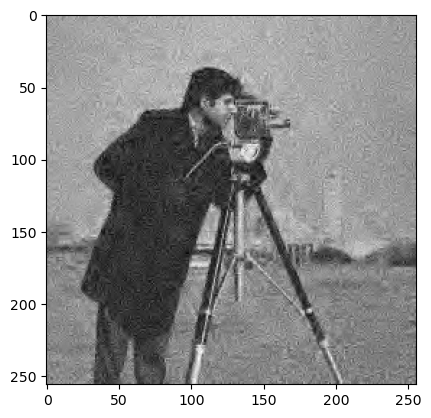

In [186]:
wavelet_type = 'db4'
level = 5
threshold_coeff = 0.8
threshold_levels = range(1, level + 1)

w_rec = wavelet_denoise(cam_noisy, wavelet_type, level, threshold_coeff, threshold_levels)

print('l2 distance: ', np.linalg.norm(w_rec - cam_true))
plt.imshow(w_rec, cmap='gray')

#### 5. Iterative soft-thresholding for X-ray tomography

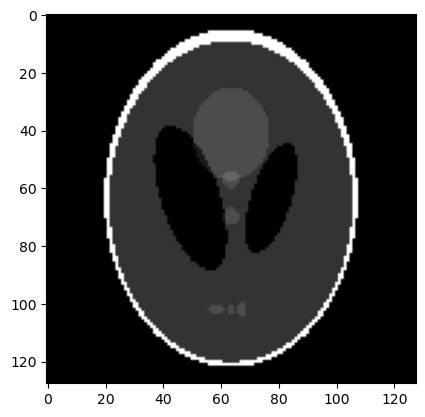

In [237]:
f_true = SLphantom
h, w = f_true.shape
plt.imshow(f_true, cmap='gray')

In [233]:
def soft_threshold(data, alpha):
    data_copy = data.copy()
    data_copy[data>=alpha] -= alpha
    data_copy[np.abs(data)<alpha] = 0
    data_copy[data<=-alpha] += alpha
    return data_copy

def error_ISTA(f, A, g):
    r_norm = np.linalg.norm(A @ f - g)
    err = r_norm * r_norm / g.shape[0]
    return err

def ISTA(A, g, h, w, lam, alpha, it_num=100, wavelet_type='db4', level=5, tol=1e-3):
    mu = lam * alpha
    
    f_old = A.T @ g
    f_old = f_old - np.min(f_old)
    f_old = f_old / np.max(f_old)
    f_old = np.power(f_old, 3)
    old_dp_alpha = 1e9
    for i in tqdm(range(it_num)):
        f_new = f_old - lam * A.T @ (A @ f_old - g)
        coeffs = wavelet_decompose(f_new.reshape((h, w)), wavelet_type, level)
        threshold_specific_levels(coeffs, mu, range(1, level + 1), soft_threshold)
        f_old = wavelet_reconstruct(coeffs, wavelet_type).reshape((h * w))
        new_dp_alpha = error_ISTA(f_old, A, g)
        if np.abs(new_dp_alpha - old_dp_alpha) < tol:
            print('Terminated for reaching the tolerance, itertions used:', i)
            return f_old.reshape((h, w))        
        old_dp_alpha = new_dp_alpha
        
    print('Terminated for reaching the max iteration.')
    return f_old.reshape((h, w))

def ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol):

    R_op = construct_Radon_Operator(h, w, n_projs, n_angles, max_angle)

    _, s, _ = scipy.sparse.linalg.svds(R_op, k=1, which='LM')
    lam = lam_coeff / s.item() / s.item()

    f_rec = ISTA(R_op, g, h, w, lam, alpha, it_num=it_num, wavelet_type=wavelet_type, level=wavelet_level, tol=tol)

    return f_rec

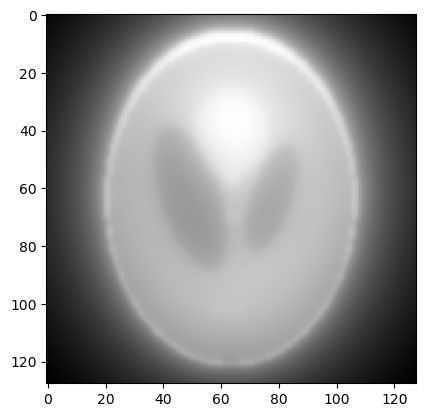

In [224]:
backp = (R_op.T @ grt.flatten()).reshape((128, 128))
backp = backp - np.min(backp)
backp = backp / np.max(backp)
backp = np.power(backp, 3)
plt.imshow((R_op.T @ grt.flatten()).reshape((128, 128)), cmap='gray')

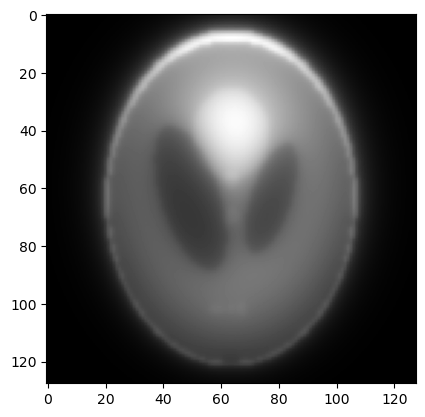

In [225]:
plt.imshow(backp, cmap='gray')

##### Experiments

 14%|█▍        | 139/1000 [00:14<01:32,  9.32it/s]

Terminated for reaching the tolerance, itertions used: 139
l2 distance:  6.0940718001295195


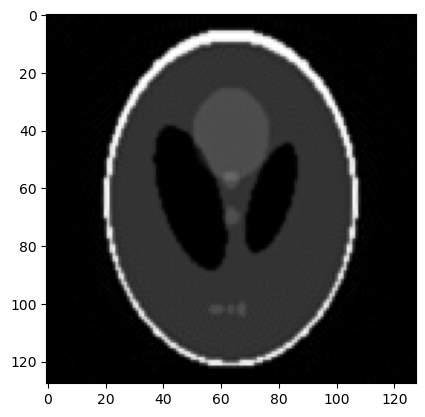

In [241]:
n_projs = 128
n_angles = 180
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 0

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 31%|███       | 312/1000 [00:33<01:14,  9.19it/s]

Terminated for reaching the tolerance, itertions used: 312
l2 distance:  18.116957376601782


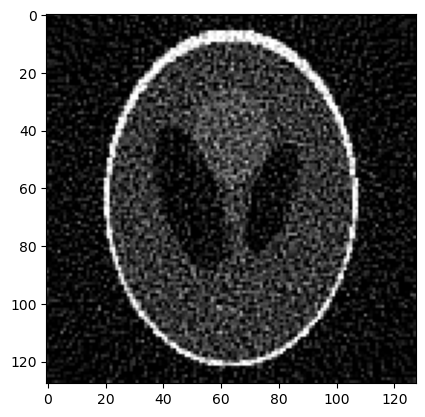

In [244]:
n_projs = 128
n_angles = 180
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 500

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 24%|██▎       | 236/1000 [00:25<01:22,  9.28it/s]

Terminated for reaching the tolerance, itertions used: 236
l2 distance:  11.935473054824309


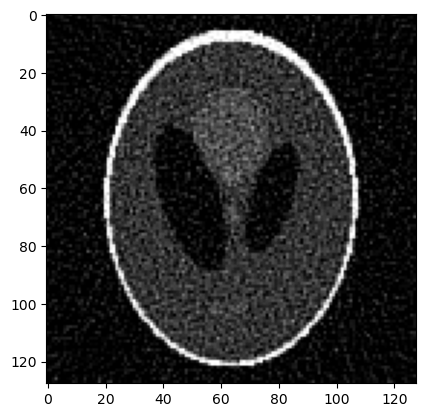

In [243]:
n_projs = 128
n_angles = 180
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 1000

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

  9%|▉         | 90/1000 [00:01<00:18, 50.10it/s]

Terminated for reaching the tolerance, itertions used: 90
l2 distance:  11.109111622976041


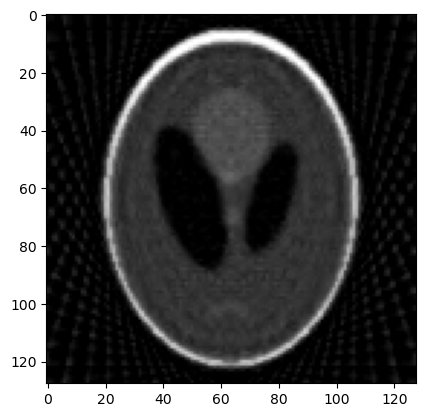

In [245]:
n_projs = 128
n_angles = 30
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 0

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 13%|█▎        | 129/1000 [00:02<00:17, 50.59it/s]


Terminated for reaching the tolerance, itertions used: 129
l2 distance:  16.769383072225093


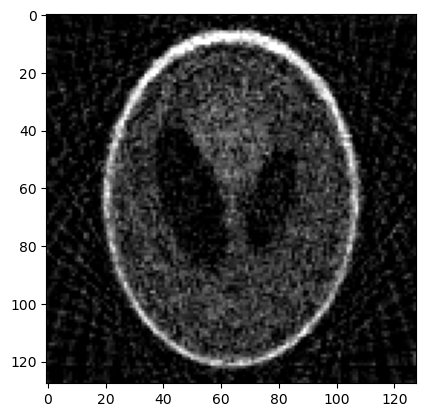

In [246]:
n_projs = 128
n_angles = 30
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 500

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 11%|█         | 112/1000 [00:02<00:17, 51.00it/s]

Terminated for reaching the tolerance, itertions used: 112
l2 distance:  14.033644804143773


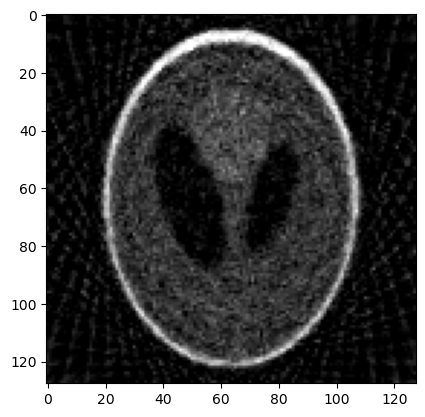

In [247]:
n_projs = 128
n_angles = 30
max_angle = np.pi

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 1000

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

  7%|▋         | 71/1000 [00:03<00:51, 17.97it/s]

Terminated for reaching the tolerance, itertions used: 71
l2 distance:  20.319059284761327


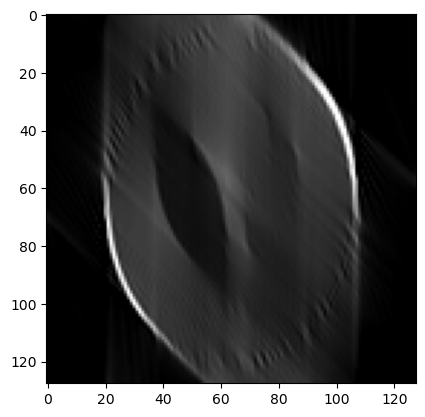

In [248]:
n_projs = 128
n_angles = 90
max_angle = np.pi / 4

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 0

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 18%|█▊        | 177/1000 [00:09<00:44, 18.34it/s]

Terminated for reaching the tolerance, itertions used: 177
l2 distance:  22.138423852885275


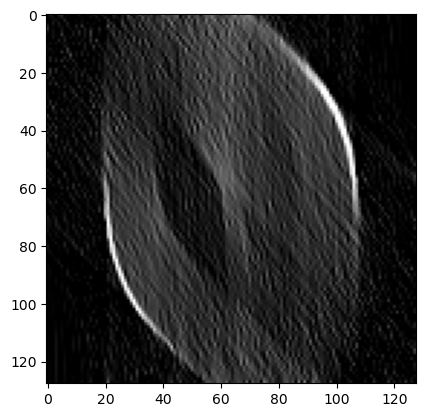

In [249]:
n_projs = 128
n_angles = 90
max_angle = np.pi / 4

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 500

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')

 12%|█▏        | 123/1000 [00:06<00:47, 18.40it/s]

Terminated for reaching the tolerance, itertions used: 123
l2 distance:  21.00770911771035


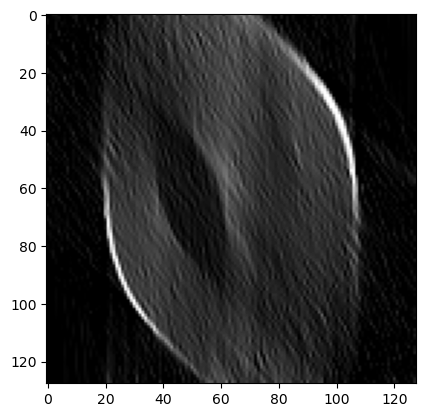

In [250]:
n_projs = 128
n_angles = 90
max_angle = np.pi / 4

alpha = 0.5
lam_coeff = 1.5
it_num = 1000
tol = 1e-3

wavelet_type = 'db4'
wavelet_level = 4

noise_level = 1000

vol_geom, proj_geom, proj_id, g_id, grt = Randon_Transform(f_true, n_projs, n_angles, max_angle)

if noise_level > 0:
    g_nosiy_id, g_noisy = add_noise_to_sino(proj_geom, grt, theta=noise_level)
    g = g_noisy.reshape((n_projs * n_angles,))
else:
    g = grt.reshape((n_projs * n_angles,))

f_rec = ISTA_Reconstruction(g, h, w, n_projs, n_angles, max_angle, lam_coeff, alpha, wavelet_type, wavelet_level, it_num, tol)

print('l2 distance: ', np.linalg.norm(f_rec - f_true))
plt.imshow(np.clip(f_rec, 0, 1), cmap='gray')